#**PROBLEMA DE NEGOCIO**


---




La necesidad de prever y optimizar el gasto de sus usuarios ha llevado a una empresa de comercio electrónico a buscar soluciones innovadoras. Como científicos de datos, hemos sido convocados para desarrollar un modelo de machine learning que pueda predecir con precisión cuánto gastará un usuario al visitar dicho sitio web.

### **Tus tareas principales serán:**

**1. Preprocesamiento de Datos:** Importar correctamente y analizar y comprender el conjunto de datos proporcionado, realizar limpieza de datos, eliminar atributos que no aportan valor y manejar valores faltantes.

**2. Exploración y Feature Engineering:** Realizar visualizaciones para entender las relaciones entre las variables y seleccionar las características relevantes, identificar variables llaves, codificación de variables categóricas y normalización/escalado de datos.

**3. Construcción de Modelos:** Experimentar con algunos algoritmos de machine learning como Linear Regression, Decision Tree Regressor, Random Forest Regressor, entre otros.

**4. Evaluación y Selección del Modelo:** Evaluar los modelos utilizando métricas como el error cuadrático medio (MSE), la raíz cuadrada del error cuadrático medio (RMSE) y el coeficiente de determinación (R²). Seleccionar el modelo con el mejor rendimiento para la predicción del gasto de los usuarios.

#**1. Configuración del Ambiente**


---




In [1]:
#!pip install wget
#import wget
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import FunctionTransformer
from joblib import dump, load
from statsmodels.stats.outliers_influence import variance_inflation_factor
global df_traffic, resultados, modelo, modelo_clasificacion

#**2. Preprocesamiento de Datos**


---


In [2]:
df= pd.read_csv(
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_site.csv',
    dtype={'date':object,'fullVisitorId':object,'visitId':object}
)
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,1,1472856802
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,2,1472879649
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,1,1472829671


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       12283 non-null  object
 1   date                  12283 non-null  object
 2   device                12283 non-null  object
 3   fullVisitorId         12283 non-null  object
 4   geoNetwork            12283 non-null  object
 5   sessionId             12283 non-null  object
 6   socialEngagementType  12283 non-null  object
 7   totals                12283 non-null  object
 8   trafficSource         12283 non-null  object
 9   visitId               12283 non-null  object
 10  visitNumber           12283 non-null  int64 
 11  visitStartTime        12283 non-null  int64 
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


In [4]:
def preprocesamiento():

  global df_traffic, df

  df_traffic = df.copy()

  diccionarios = ["device","geoNetwork","trafficSource","totals"]
  for columna in diccionarios:
      df_traffic = df_traffic.join(pd.DataFrame([json.loads(linea) for linea in df_traffic[columna]]))
      df_traffic = df_traffic.drop(columna,axis=1)

  df_traffic = df_traffic.drop("adwordsClickInfo",axis=1)

  columnas = [
      'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
      'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
      'browser', 'browserVersion', 'browserSize', 'operatingSystem',
      'operatingSystemVersion', 'isMobile', 'mobileDeviceBranding',
      'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo',
      'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors',
      'screenResolution', 'deviceCategory', 'continent', 'subContinent',
      'country', 'region', 'metro', 'city', 'cityId', 'networkDomain',
      'latitude', 'longitude', 'networkLocation', 'campaign', 'source',
        'medium', 'keyword', 'isTrueDirect', 'referralPath', 'adContent',
        'campaignCode', 'visits', 'hits', 'pageviews', 'bounces', 'newVisits',
        'transactionRevenue']

  for columna in columnas:
    df_tamaño = len(df_traffic[columna].unique())

  columnas_eliminar = ["socialEngagementType","browserVersion","browserSize",
                      "operatingSystemVersion","mobileDeviceBranding","mobileDeviceModel",
                      "mobileInputSelector","mobileDeviceInfo","mobileDeviceMarketingName",
                      "flashVersion","language","screenColors",
                      "screenResolution","latitude","longitude",
                      "networkLocation","visits"]

  df_traffic = df_traffic.drop(columnas_eliminar,axis=1)

  columnas_mantener = ["channelGrouping","date","fullVisitorId",
                      "sessionId","visitId","referralPath",
                      "city","metro","visitNumber",
                      "visitStartTime","browser","operatingSystem",
                      "isMobile","deviceCategory","campaign",
                      "source","medium","hits",
                      "pageviews","bounces","newVisits","transactionRevenue"]

  df_traffic = df_traffic[columnas_mantener]

  nulos = df_traffic.isnull().sum()

  if nulos.any() > 0:
    df_traffic = df_traffic.fillna(0)
  else:
    df_traffic = df_traffic
  cuant = ['bounces', 'hits','newVisits','pageviews', 'transactionRevenue']
  for columna in cuant:
      df_traffic[columna] = pd.to_numeric(df_traffic[columna])

  df_traffic["transactionRevenue"] = df_traffic["transactionRevenue"]/1000000

  df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%Y%m%d')

  df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'], unit='s')

  df_traffic['date'] = pd.to_datetime(df_traffic['date'], format='%Y%m%d')

  df_traffic['visitStartTime'] = pd.to_datetime(df_traffic['visitStartTime'], unit='s')

  # df_traffic['interaction'] = df_traffic['source'] + '_' + df_traffic['deviceCategory'] # Variable extra, que agregue.

  return df_traffic

df_traffic = preprocesamiento()

In [5]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   channelGrouping     12283 non-null  object        
 1   date                12283 non-null  datetime64[ns]
 2   fullVisitorId       12283 non-null  object        
 3   sessionId           12283 non-null  object        
 4   visitId             12283 non-null  object        
 5   referralPath        12283 non-null  object        
 6   city                12283 non-null  object        
 7   metro               12283 non-null  object        
 8   visitNumber         12283 non-null  int64         
 9   visitStartTime      12283 non-null  datetime64[ns]
 10  browser             12283 non-null  object        
 11  operatingSystem     12283 non-null  object        
 12  isMobile            12283 non-null  bool          
 13  deviceCategory      12283 non-null  object    

#**3. Exploración y Feature Engineering**


---


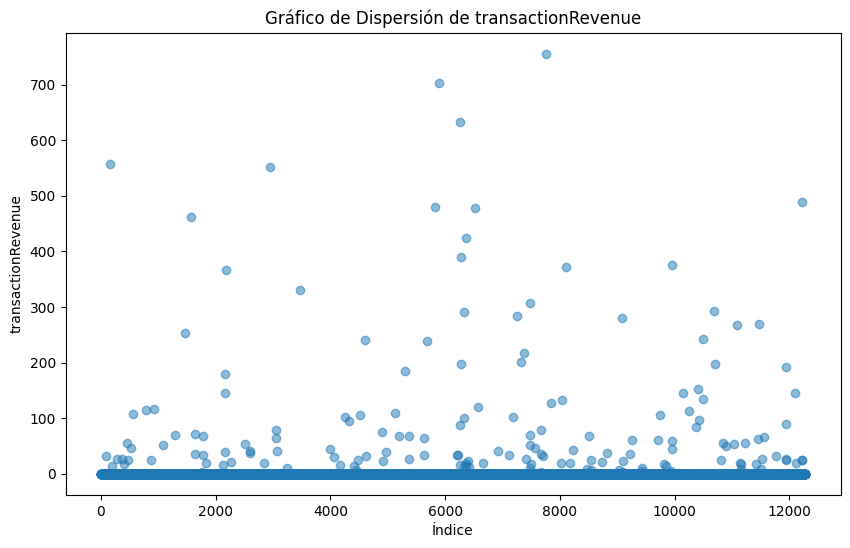

In [6]:
# Grafico de dispersión (antes)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(df_traffic['transactionRevenue'])), df_traffic['transactionRevenue'], alpha=0.5)
plt.title('Gráfico de Dispersión de transactionRevenue')
plt.xlabel('Índice')
plt.ylabel('transactionRevenue')
plt.show()

Podemos observar que la mayoría de las personas no realizaron ninguna compra, fue tanta la cantidad que se genero un línea recta en 0. Tambien podemos observar que tenemos valores que están por encima de esta linea, pero con no son muchos, esto indica las pocas personas que realizaron compras.

<Axes: ylabel='transactionRevenue'>

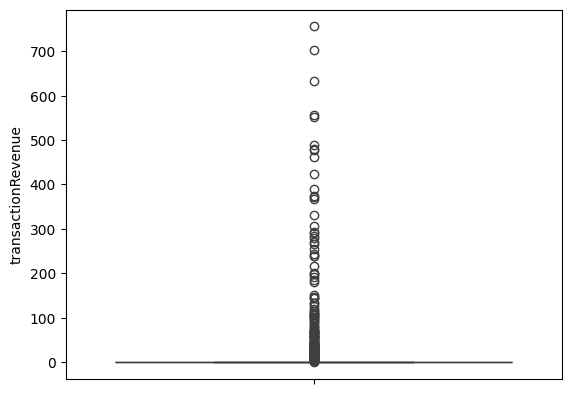

In [7]:
sns.boxplot(df_traffic.transactionRevenue)

Podemos observas que según la gráfica nuestros valores en su mayoría serían atípicos, aunque parece ser así, con la gráfica anterior podemos observar que en verdad la mayoría de los valores están concentrados en 0. Mientras que el resto, fueron todos aquellos que realizaron compras, sin embargo, aunque estos son valores en teoría atípicos, no serán descartados ya que son escenciales para la construcción de nuestro modelo, esto debido a que los pocos datos "atípicos" son en realidad las pocas personas que realizaron un gasto. Veamos un conteo para ver más claro esta información:

In [8]:
# Realizando el conteo de los datos para la columna trasactionRvenue.

df_traffic.transactionRevenue.value_counts()

0.00      12119
19.19         3
13.59         3
33.59         3
55.99         2
          ...  
38.38         1
109.57        1
67.19         1
184.05        1
105.48        1
Name: transactionRevenue, Length: 147, dtype: int64

Como observamos la mayoría de las personas o de nuestros registros no realizaron ninguna compra, es decir tenemos 12119 registros/personas que no gastaron nada.

In [9]:
# Vamos a crear dos variables para observar la cantidad de registros que tuvieron gastos y los que no
# y estas variables nos serviran más adelante para entrenar nuestros modelos de una manera distinta.

# Registros que no tuvieron gastos.

registros_sin_gastos = df_traffic[df_traffic["transactionRevenue"] == 0]
porcentaje_registros__sin_gastos = len(registros_sin_gastos)/df_traffic.shape[0] * 100

# Registros con gastos mayores a 0.

registros_con_gastos = df_traffic[df_traffic["transactionRevenue"] > 0 ]
porcentaje_registros_con_gastos = len(registros_con_gastos)/df_traffic.shape[0] * 100

print(f"""Registros con gastos igual a 0: {len(registros_sin_gastos)} es decir el {round(porcentaje_registros__sin_gastos,2)}%
del total de registros y tenemos registros con gastos mayores a 0: {len(registros_con_gastos)}
es decir el {round(porcentaje_registros_con_gastos,2)}% del total de registros""")

Registros con gastos igual a 0: 12119 es decir el 98.66%
del total de registros y tenemos registros con gastos mayores a 0: 164
es decir el 1.34% del total de registros


Al observar esto, podemos determinar que hay una gran cantidad de registros donde el valor es igual a 0 y apenas los registros con valores mayores a 0 son unos 164.

In [10]:
df_traffic.describe()

,visitNumber,hits,pageviews,bounces,newVisits,transactionRevenue
count,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000,12283.000000
mean,1.923390,4.637141,3.871286,0.502483,0.768949,1.447871
std,5.878228,10.136882,7.273662,0.500014,0.421522,20.893896
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000
75%,1.000000,4.000000,4.000000,1.000000,1.000000,0.000000
max,195.000000,471.000000,305.000000,1.000000,1.000000,755.630000


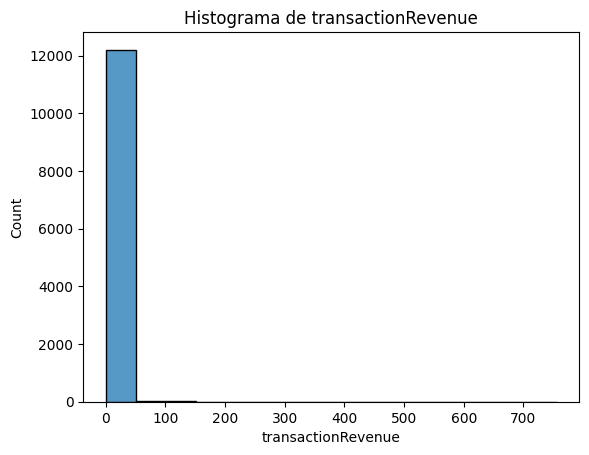

In [11]:
#Histograma (antes)
ax = sns.histplot(data=df_traffic, x='transactionRevenue', kde=False)
ax.set_title('Histograma de transactionRevenue')
ax.set_xlabel('transactionRevenue');

In [12]:
def feature_engineering():

    # Volvemos a definir las variables globales.

    global df_traffic

    # Usando lambda y .year estaremos extrayendo de la columna date el año y almacenando
    # ese año en la nueva columna llamada year.

    df_traffic['year'] = df_traffic['date'].apply(lambda x:x.year)

    # Usando lambda y .month estaremos extrayendo de la columna date el mes y almacenando
    # ese mes en la nueva columna llamada month.

    df_traffic['month'] = df_traffic['date'].apply(lambda x:x.month)

    # Usando lambda y .quarterMonth estaremos extrayendo de la columna date el cuarto de mes y almacenando
    # ese cuarto de mes en la nueva columna llamada quarterMonth.

    df_traffic['quarterMonth'] = df_traffic['date'].apply(lambda x: 1 if x.day <= 7 else 2 if x.day <= 14 else 3 if x.day <= 21 else 4)

    # Usando lambda y .day estaremos extrayendo de la columna date el día y almacenando
    # ese día en la nueva columna llamada day.

    df_traffic['day'] = df_traffic['date'].apply(lambda x:x.day)

    # Usando lambda y .weekday estaremos extrayendo de la columna date el día de fin de semana y almacenando
    # ese día en la nueva columna llamada weekday.

    df_traffic['weekday'] = df_traffic['date'].apply(lambda x:x.weekday)

    df_traffic['time_range'] = (
        pd.cut(
            df_traffic['visitStartTime'].dt.hour,
            bins=[0, 6, 12, 18, 24],
            labels=['madrugada', 'mañana', 'tarde', 'noche'],
            ordered=False
        )
        .astype('object')
    )

    eliminar_columna = ['date','fullVisitorId','sessionId','visitId','visitStartTime','year']

    df_traffic  = df_traffic.drop(eliminar_columna,axis=1)

    cualitativas = df_traffic.dtypes[df_traffic.dtypes == object].keys()

    for columna in cualitativas:
        lbl = LabelEncoder()
        strings = list(df_traffic[columna].values.astype('str'))
        lbl.fit(strings)
        df_traffic[columna] = lbl.transform(strings)
    df_traffic.reset_index(inplace=True, drop=True)

    #Columnas que no son necesarios y que puede no aportar nada al modelo  # quitar "metro","pageviews","channelGrouping" de aquí luego de probar ,"quarterMonth","source","deviceCategory","channelGrouping"
    columnas_sin_aporte = ["referralPath"]

    df_traffic.drop(columnas_sin_aporte,axis = 1, inplace=True)

    return df_traffic

df_traffic = feature_engineering()

In [13]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   channelGrouping     12283 non-null  int64  
 1   city                12283 non-null  int64  
 2   metro               12283 non-null  int64  
 3   visitNumber         12283 non-null  int64  
 4   browser             12283 non-null  int64  
 5   operatingSystem     12283 non-null  int64  
 6   isMobile            12283 non-null  bool   
 7   deviceCategory      12283 non-null  int64  
 8   campaign            12283 non-null  int64  
 9   source              12283 non-null  int64  
 10  medium              12283 non-null  int64  
 11  hits                12283 non-null  int64  
 12  pageviews           12283 non-null  int64  
 13  bounces             12283 non-null  int64  
 14  newVisits           12283 non-null  int64  
 15  transactionRevenue  12283 non-null  float64
 16  mont

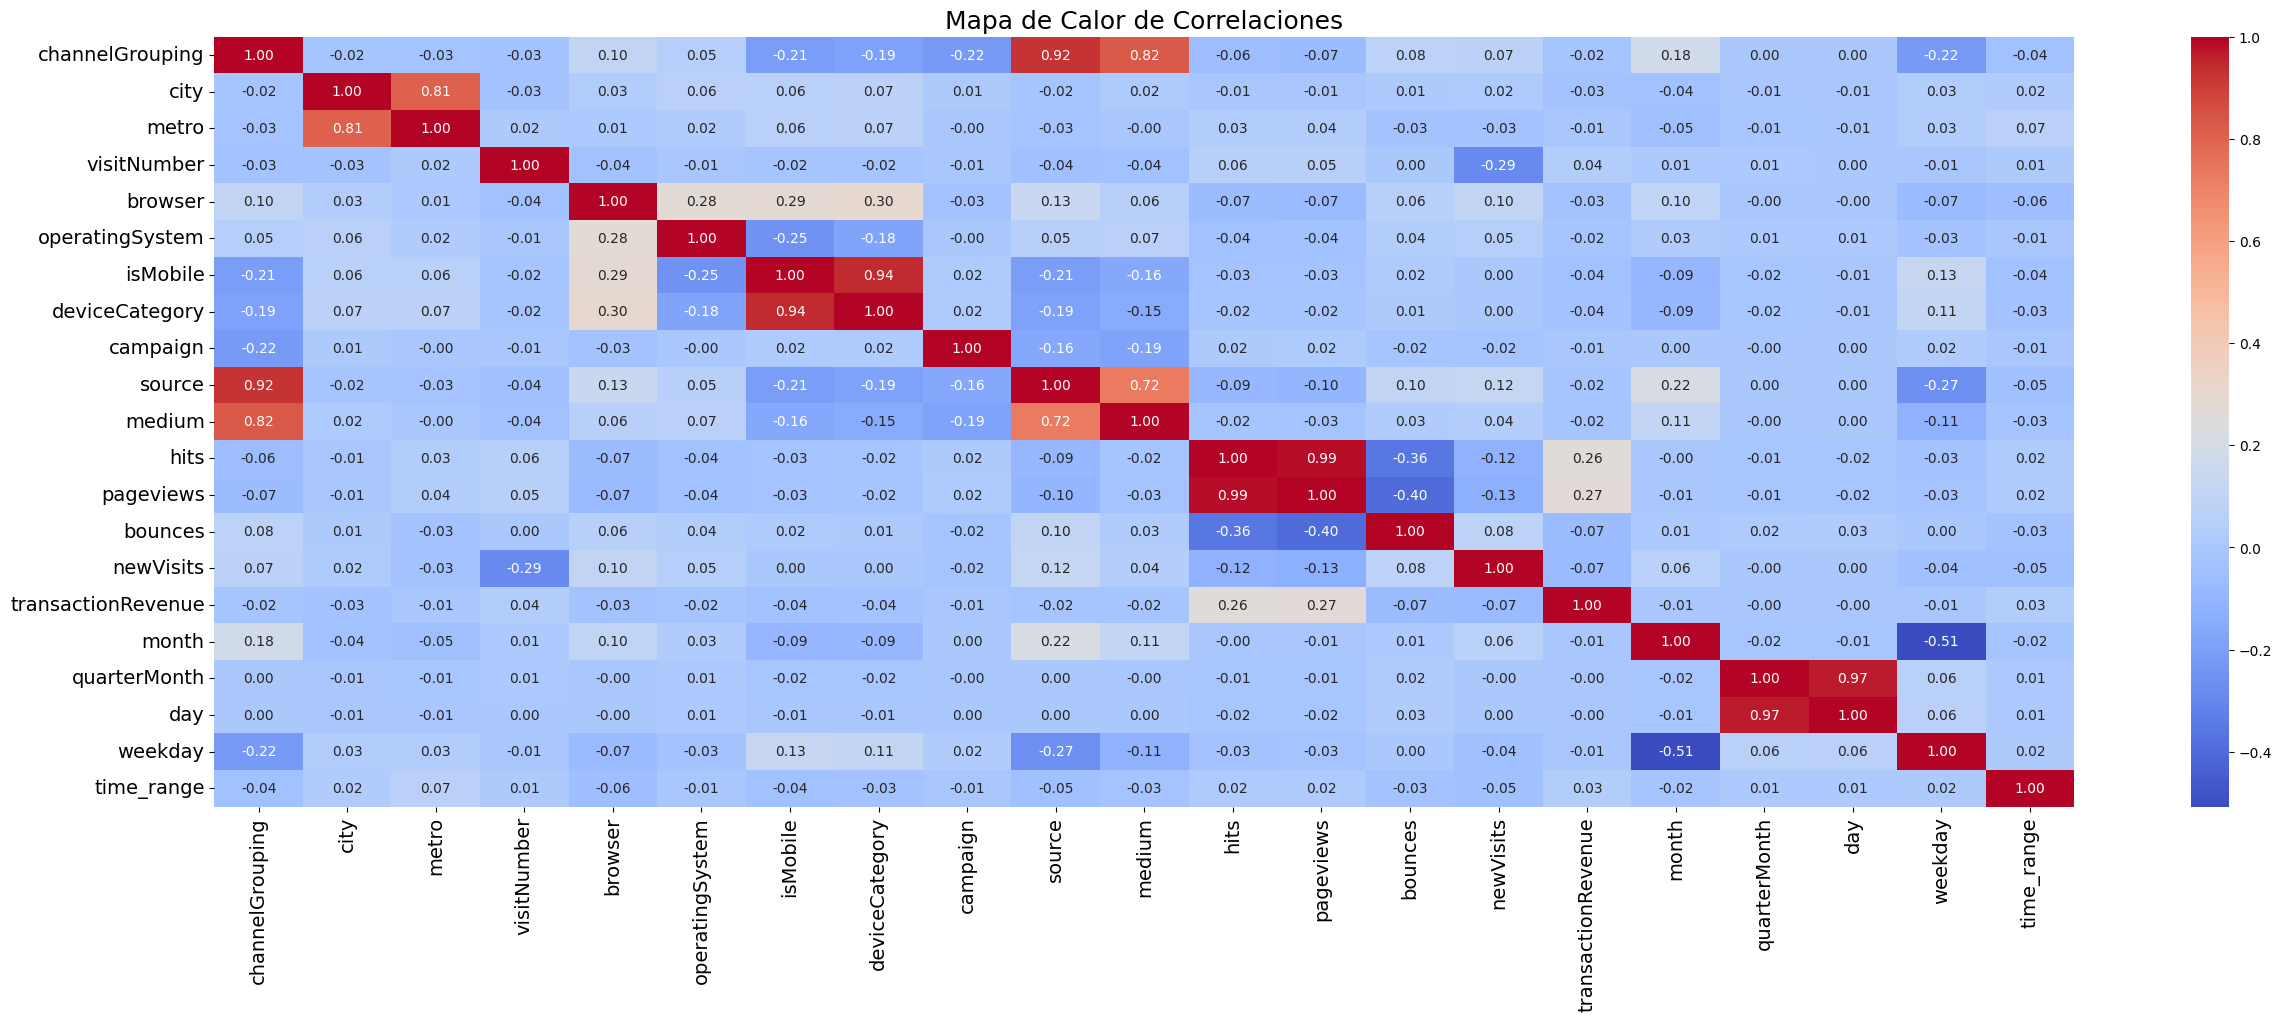

In [14]:
plt.figure(figsize=(30, 10))
heatmap = sns.heatmap(df_traffic.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
heatmap.tick_params(axis='both', which='major', labelsize=14)
plt.title('Mapa de Calor de Correlaciones', fontsize=18)
plt.show()

In [15]:
df_traffic

,channelGrouping,city,metro,visitNumber,browser,operatingSystem,isMobile,deviceCategory,campaign,source,medium,hits,pageviews,bounces,newVisits,transactionRevenue,month,quarterMonth,day,weekday,time_range
0,4,250,0,1,5,9,False,0,0,23,5,1,1,1,1,0.0,9,1,2,32,1
1,4,295,52,1,5,6,False,0,0,23,5,1,1,1,1,0.0,9,1,2,32,4
2,1,43,0,1,5,6,False,0,4,3,2,1,1,1,1,0.0,9,1,2,32,3
3,4,295,52,2,18,11,True,1,0,23,5,1,1,1,0,0.0,9,1,2,32,0
4,4,295,52,1,18,11,True,1,0,23,5,5,4,0,1,0.0,9,1,2,32,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12278,7,295,52,1,5,9,False,0,0,75,6,1,1,1,1,0.0,1,1,4,156,4
12279,7,295,52,1,5,1,True,1,0,75,6,1,1,1,1,0.0,1,1,4,156,0
12280,7,295,52,1,5,5,False,0,0,75,6,1,1,1,1,0.0,1,1,4,156,0
12281,7,295,52,2,5,1,True,1,0,75,6,2,2,0,0,0.0,1,1,4,156,1


In [16]:
df_traffic.columns

Index(['channelGrouping', 'city', 'metro', 'visitNumber', 'browser',
       'operatingSystem', 'isMobile', 'deviceCategory', 'campaign', 'source',
       'medium', 'hits', 'pageviews', 'bounces', 'newVisits',
       'transactionRevenue', 'month', 'quarterMonth', 'day', 'weekday',
       'time_range'],
      dtype='object')

In [17]:
# Creando la variable excluyendo
excluyendo= df_traffic.drop("transactionRevenue",axis=1)

# Selecciona solo las columnas numéricas (excluyendo las categóricas)
numeric_columns = excluyendo.select_dtypes(include=['float64', 'int64'])

# Calculando el VIF para cada variable
vif = pd.DataFrame()
vif['Variable'] = numeric_columns.columns
vif['VIF'] = [variance_inflation_factor(numeric_columns.values, i) for i in range(numeric_columns.shape[1])]

# Muestra los valores de VIF
print(vif)

           Variable        VIF
0   channelGrouping  64.479683
1              city  20.614662
2             metro  11.728812
3       visitNumber   1.198701
4           browser   4.407886
5   operatingSystem   6.792162
6    deviceCategory   1.711632
7          campaign   1.084474
8            source  16.491652
9            medium  17.815109
10             hits  47.449844
11        pageviews  51.740275
12          bounces   2.457790
13        newVisits   4.579894
14            month   5.618283
15     quarterMonth  84.588335
16              day  58.960022
17          weekday   4.620264
18       time_range   2.974608


#**4. Construcción de Modelos**


---


In [18]:
def crea_modelos():
    global df_traffic, resultados, modelo, modelo_clasificacion
    """
        Como nuestra base tiene muchos 0 y pocos valores mayores a 1. Vamos a aplicar el método de de Gamma Hurdle
        en donde primero convertiremos nuestra variable en binario, donde 0 == 0 y 1 serán los > 0. Esto nos va a
        permitir trabajar nuestros datos dentro de un modelo de clasificación, para que de esta forma podamos
        crear una nueva variable predictora a partir de las predicciones realizadas con nuestro modelo de clasificación
        entrenado. Esto con el fin de generar un variable que nos permita añadir valor a nuestros datos y predicir de
        manera más precisa.

    """

    # Modelo de clasificación

    ## Eliminando nuestra columna transactionRevenue en X para quedarnos solo con las variables predictoras

    X = df_traffic.drop('transactionRevenue',axis=1)

    ## Seleccionando solamente nuestra variable transactionRevenue y creando la copy sobnre la cual trabajremos
    ## guardando los resultados en y, esta varible y hace referencia a la variable respuesta o dependiente, que
    ## es lo que buscamos predecir.

    y = df_traffic.transactionRevenue.copy().apply(lambda x: 0 if x == 0 else 1)

    ## Ahora separamos nuestras variables en un porcentaje para test y otro para entrenamiento
    ## las que sean train, serán con las cuales entrenemos nuestro modelo y las test serán las
    ## que usaremos para entrenar el modelo.

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state = 42
    )

    ## creando nuestro modelo

    model_clasi = RandomForestClassifier(n_estimators=100, random_state=42)
    ## entrenando el modelo
    model_clasi.fit(X_train,y_train)
    modelo_clasificacion = model_clasi

    # Modelo de regresión

    ## Añdiendo una nueva columna a nuestras variables predictoras usando el modelo de clasificación
    ## para determinar las posibles compras que se harán, usando las variables predictoras del modelo
    ## anterior que serían lo mismo para este modelo sin la variable que estamos anexando en estos
    ## momentos

    X = df_traffic.drop('transactionRevenue',axis=1)
    X["clasificacion"] = model_clasi.predict(X)
    y = df_traffic.transactionRevenue.copy()
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.30, random_state = 42
        )


    # Regresión lineal

    model = LinearRegression()
    model.fit(train_x, train_y)

    ## Predicciones

    predictions = model.predict(test_x)
    predictions[predictions < 0] = 0


    r2 = r2_score(test_y, predictions)*100
    mse = mean_squared_error(test_y, predictions)
    rmse = np.sqrt(mse)

    print(f"R-cuadrado (R²): {r2}")
    print(f"Error cuadrático medio (MSE): {mse}")
    print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

    # LGB MODEL

    lgb_params = {
        "objective": "regression",
        "metric": "rmse",
        'subsample': 0.67,
        'reg_lambda': 0.031,
        'reg_alpha': 0.029,
        'num_leaves': 16,
        'min_child_samples': 14,
        'max_depth': 5,
        'learning_rate': 0.042,
        'colsample_bytree': 0.66,
        'verbosity': -1
    }

    lgb_train = lgb.Dataset(train_x, label = train_y)
    lgb_val = lgb.Dataset(test_x, label = test_y)
    lgb_model = lgb.train(
        lgb_params, lgb_train,
        num_boost_round = 700,
        valid_sets = [lgb_val],
        callbacks = [lgb.early_stopping(stopping_rounds = 500)]
    )
    # XGBoost Model
    params = {
        "objective": "reg:squarederror", # para problemas de regresión
        "eval_metric": "rmse", # métrica de evaluación: error cuadrático medio
        'subsample': 0.88,
        'reg_lambda': 0.095,
        'reg_alpha': 0.01,
        'random_state': 42,
        'n_estimators': 230,
        'min_child_weight': 5,
        'max_depth': 6,
        'learning_rate': 0.046,
        'gamma': 0.105,
        'colsample_bytree': 0.9
    }
    dtrain = xgb.DMatrix(train_x, label = train_y)
    dtest = xgb.DMatrix(test_x, label = test_y)
    evals = [(dtrain,"train"),(dtest,"test")]

    xgb_model = xgb.train(
        params,dtrain,num_boost_round = 1000,
        evals = evals, early_stopping_rounds = 10,
        verbose_eval = False
        )

    models = {
                "Regresión Lineal": LinearRegression(),
                "Random Forest": RandomForestRegressor(),
                "LightGBM": lgb_model,
                "XGBoost": xgb_model
            }

    results = {"Model": [], "R2": [], "MSE": [], "RMSE": []}

    for name, model in models.items():
        if name == "LightGBM":
            predictions = model.predict(
                test_x, num_iterations=model.best_iteration
                )
            predictions[predictions < 0] = 0
            modelo = model
        elif name == "Random Forest":
        #Definir el espacio de búsqueda de hiperparámetros
            param_dist = {
                "n_estimators": [
                    int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)
                    ],
                "max_features": ["sqrt"],
                "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],
                "min_samples_split": [2, 5, 10],
                "min_samples_leaf": [1, 2, 4],
                "bootstrap": [True, False]
            }
            #Realizar busqueda aleatoria
            random_search = RandomizedSearchCV(
                model, param_distributions=param_dist,
                n_iter = 50, cv = 5, scoring = "r2", random_state = 42
            )
            random_search.fit(train_x,train_y)

            #Obtener el mejor modelo
            predictions = random_search.best_estimator_.predict(test_x)
            predictions[predictions < 0] = 0

        elif name == "XGBoost":
            predictions = model.predict(dtest)
            predictions[predictions < 0] = 0
        else:
            model.fit(train_x, train_y)
            predictions = model.predict(test_x)
            predictions[predictions < 0] = 0

        r2  = r2_score(test_y, predictions) * 100
        mse = mean_squared_error(test_y, predictions)
        rmse = np.sqrt(mse)

        results["Model"].append(name)
        results["R2"].append(r2)
        results["MSE"].append(mse)
        results["RMSE"].append(rmse)

    dump(modelo, "modelo.joblib")
    dump(modelo_clasificacion, "modelo_clasificacion.joblib")
    resultados = results

In [19]:
crea_modelos()
for i, model in enumerate(resultados['Model']):
    print('-------------------------------')
    print(f"Modelo: {model}")
    print(f"R-cuadrado (R²): {resultados['R2'][i]}")
    print(f"Error cuadrático medio (MSE): {resultados['MSE'][i]}")
    print(f"Raíz del error cuadrático medio (RMSE): {resultados['RMSE'][i]}")
    print('-------------------------------')

R-cuadrado (R²): 31.194466651556773
Error cuadrático medio (MSE): 262.6771107898274
Raíz del error cuadrático medio (RMSE): 16.207316582020216
Training until validation scores don't improve for 500 rounds
Did not meet early stopping. Best iteration is:
[507]	valid_0's rmse: 14.0579
-------------------------------
Modelo: Regresión Lineal
R-cuadrado (R²): 31.194466651556773
Error cuadrático medio (MSE): 262.6771107898274
Raíz del error cuadrático medio (RMSE): 16.207316582020216
-------------------------------
-------------------------------
Modelo: Random Forest
R-cuadrado (R²): 37.92423806304966
Error cuadrático medio (MSE): 236.98503597231672
Raíz del error cuadrático medio (RMSE): 15.394318301643523
-------------------------------
-------------------------------
Modelo: LightGBM
R-cuadrado (R²): 50.251718676195445
Error cuadrático medio (MSE): 189.9227310501209
Raíz del error cuadrático medio (RMSE): 13.781245627668092
-------------------------------
-------------------------------


#**5. Evaluación y Selección del Modelo**


---


In [20]:
def visualiza_resultados():
    global resultados

    results_df = pd.DataFrame(resultados)
    results_df.set_index('Model', inplace=True)

    results_df = results_df.T
    colors = ['#0077b6', '#CDDBF3','#9370DB', '#DDA0DD']
    results_df.plot(
        kind='bar', figsize=(12, 6),
        colormap='viridis', rot=0, color=colors
        )
    plt.title('Comparación de Métricas por Modelo')
    plt.xlabel('Métricas')
    plt.ylabel('Puntuación')
    plt.legend(title='Modelos')
    plt.tight_layout()
    plt.show()

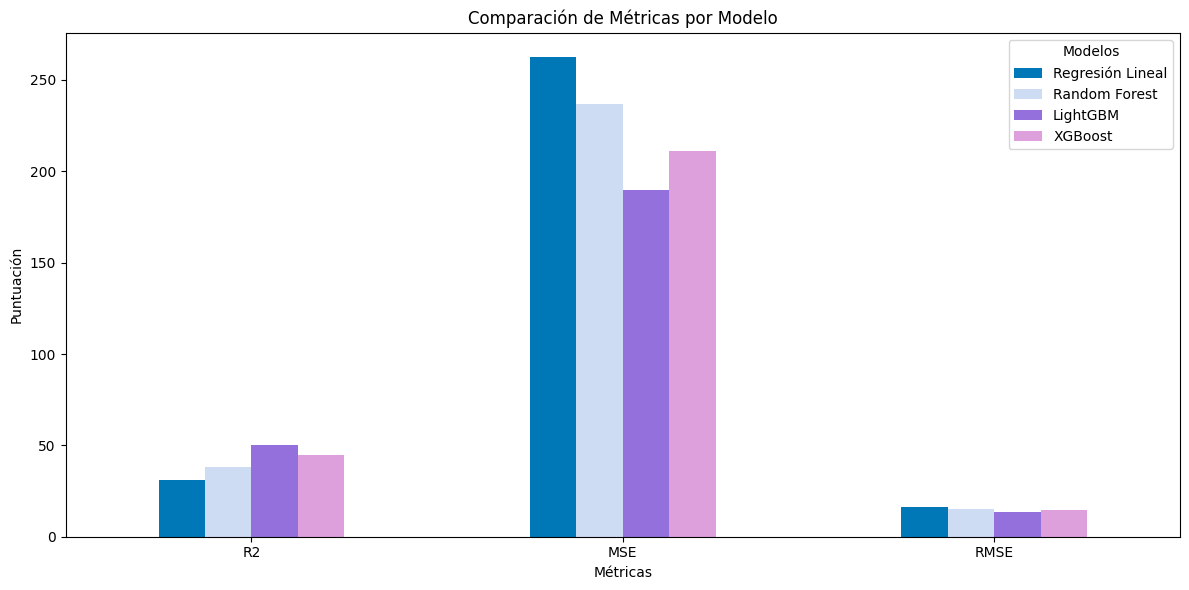

In [21]:
visualiza_resultados()

#**6. Producción**


---


In [22]:
#Cargar base de prueba y ejecutar normalización utilizada en nuestro modelo
df_traffic = pd.read_csv(
    'https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/traffic_test.csv',
    dtype={'date':object,'fullVisitorId':object,'visitId':object}
)
preprocesamiento()
feature_engineering()

#Cargar el modelo entrenado
modelo = load('modelo.joblib')
modelo_clasificacion = load('modelo_clasificacion.joblib')

#Pronosticar con la nueva base
X = df_traffic.drop('transactionRevenue',axis=1)
X['clasificacion'] = modelo_clasificacion.predict(X)
y = df_traffic.transactionRevenue.copy()
predictions = modelo.predict(X)
predictions[predictions < 1] = 0

#Genera algunas métricas de evaluación de los pronosticos
r2 = r2_score(y, predictions)*100
mse = mean_squared_error(y, predictions)
rmse = np.sqrt(mse)
print(f"R-cuadrado (R²): {r2}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Raíz del error cuadrático medio (RMSE): {rmse}")

R-cuadrado (R²): 79.25451957080296
Error cuadrático medio (MSE): 90.55803414139726
Raíz del error cuadrático medio (RMSE): 9.516198513135235


In [23]:
#Ejemplos de los pronósticos
df_resultados = pd.DataFrame({
    'transactionRevenue': y,
    'predictions': predictions
})
df_resultados[df_resultados.transactionRevenue>0].sample(10)

,transactionRevenue,predictions
1086,52.02,97.316318
4321,95.18,107.286910
6663,19.95,43.250840
1786,67.18,7.582571
6408,23.49,0.000000
4249,101.95,133.129860
8821,36.78,0.000000
6337,100.78,91.323425
5204,67.19,62.621311
2165,145.99,101.149405
